#### Last Modified: August 15th, 2022 (Opal).

## sOpInf Applied to HUX Solar Wind Radial Speed Dataset for CR2210


In [1]:
import os
curr_dir = os.getcwd()
os.chdir("../")
print("current directory path = ", os.getcwd())

current directory path =  /Users/oissan/PycharmProjects/Space-Weather-ROM-Revised


In [2]:
import numpy as np
import scipy.linalg as la
from scipy.integrate import solve_ivp
from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.model.variable import Variable
import rom_operator_inference as roi
from scipy import stats
from notebook_functions import *
from hux_code.numerical_methods import apply_numerical_method
from hux_code.hux_propagation import apply_hux_f_model
import time
import astropy.units as u

In [3]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

### Import MHD solar wind velocity results.

In [4]:
# mas output - br, rho, vr
cr = "2210"
mas_path = get_mas_path(cr=cr)
model = MASOutput(mas_path)
# read in MHD velocity results. 
vr_model = model['vr']

In [5]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = vr_model.phi_coords
r = (vr_model.r_coords * u.solRad).to(u.km) 
# velocity profile 
f = vr_model.data
print(f.shape)

(128, 111, 140)


In [6]:
omega_rot = (2 * np.pi) / (25.38 * 86400)

In [7]:
#force periodicity on f
#since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p = np.append(p, 2*np.pi) 

# append the first slice p=0 to velocity matrix. 
f = np.append(f,[f[0,:, :]],axis=0)

In [8]:
# solve for the velocity field using HUX code. 
V = apply_hux_f_model(f[:, 55, 0], (r[1:]-r[:-1]).to(u.km).value, p[1:] -p[:-1]).T

In [9]:
V.shape

(129, 140)

### Background:  Solar Wind

Due to the high temperature of the Sun's upper atmosphere, called the corona, particles are able to escape the Sun's gravity, resulting in the Solar Wind. The solar wind is a stream of charged particles mostly consists of electrons, protons and alpha particles. The solar wind varies in density, temperature and speed over time and over solar latitude and longitude.

Here we will model the radial velocity of the Solar Wind protons denoted by $v_{r}$. As the solar wind propagates out in the heliosphere it can reach velocities of around 300-700 km/sec. 

In [10]:
def plot_heat_data(Z, title, sample_columns=np.append(np.arange(0, len(r), 20),len(r) -1), variable="v", xlabel="$\phi$ (Deg.)", 
                  save_fig=False, file_name=None):
    fig, ax = plt.subplots(figsize=(14, 4))
    color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

    for j in sample_columns:
        x_all = np.concatenate([[0], Z[:,j], [0]])  # Pad results with boundary conditions.
        ax.plot(p*(180/np.pi), Z[:,j], color=next(color), label=str(variable) + rf"$(\phi,r$" + "=" + 
                str(round(r[j].to(u.AU).value,2)) + " AU)")

    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_xticks([0, 90, 180, 270, 360])
    ax.set_ylabel(variable + " (km/s)", fontsize=15)
    ax.legend(loc=(1.05, .05))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    fig.suptitle(title, fontsize=15)
    
    if save_fig:
        fig.savefig(file_name, dpi=500, bbox_inches='tight')

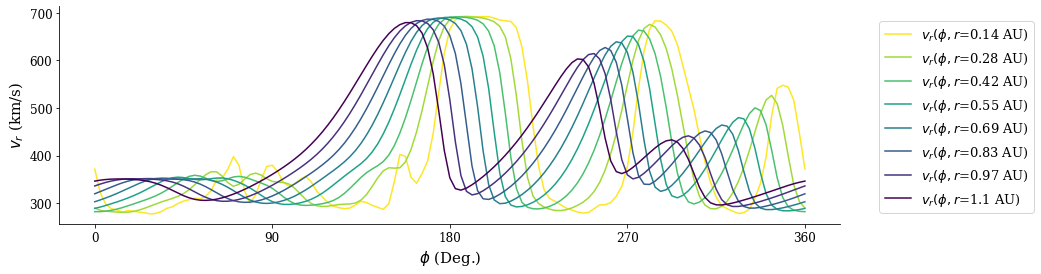

In [11]:
plot_heat_data(V, "", variable=r"$v_{r}$", save_fig=True, file_name="HUX/figs/CR"+ str(cr) +"/original_dataset_HUX.png")

In [12]:
def shift_function(r, r_idx, m=0, b=0, method="moc"):
    if method=="cce":
        return None
    if method=="moc":
        return np.loadtxt('HUX/shock_curve_S1.csv', delimiter=',')[r_idx]

In [13]:
V_new = np.zeros((len(p), len(r)))

V_new[:, 0] = V[:, 0]

for jj in range(1, len(r)):
    # compute shift from the linear fit above. 
    shift = shift_function(r[jj].to(u.AU).value,r_idx=jj, m=0, b=0, method='moc')
    # interpolate over the shifted coordinate
    V_new[:, jj] = np.interp(p + shift*(np.pi/180), p, V[:, jj], period=2*np.pi)

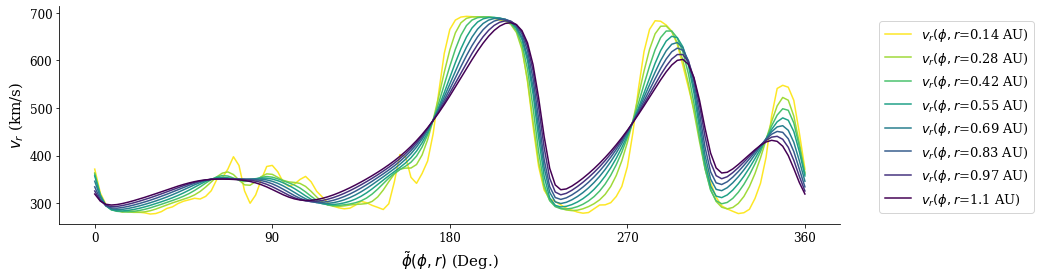

In [14]:
plot_heat_data(V_new, "", variable=r"$v_{r}$", xlabel=r"$\tilde{\phi}(\phi, r)$ (Deg.)", 
              save_fig=True, file_name="HUX/figs/CR"+ str(cr) +"/shifted_dataset_HUX.png")

## Split Training and Testing datasets. 

* Training = First $l$ radial indexes.
* Testing/Validation = Remaining $n_{r}-l$ radial indexes.

In [15]:
# set up the first l indexes used for training. 
l = int(0.7*(len(r)))

In [16]:
X=V_new

In [17]:
X_train = V_new[:, :l]
X_test = V_new[:, l:]

In [18]:
r_train = r[:l]
r_test = r[l:]

In [19]:
print("X train shape", np.shape(X_train))
print("Radial distance train: " + str(r[0].to(u.AU)) + " to " + str(r[l].to(u.AU)))
print("\nX test shape", np.shape(X_test))
print("Radial distance test: " + str(r[l].to(u.AU)) + " to " + str(r[-1].to(u.AU)))

X train shape (129, 98)
Radial distance train: 0.13951401782886472 AU to 0.816444039517221 AU

X test shape (129, 42)
Radial distance test: 0.816444039517221 AU to 1.0996495197497314 AU


## Using the ROM Operator Inference Package

## Linear ROM: $\frac{d}{dr}\hat{\mathbf{v}}(r) = \hat{A}\hat{\mathbf{v}}$


### Can we improve prediction by regularization? to avoid overfitting to the training dataset. Find the optimal regularization coefficient $\lambda_{1}$.

In [20]:
coeff_array = 10**np.arange(0, 10)
rank_array = np.arange(2, 20)

training_error_A = np.ones((len(coeff_array), len(rank_array), 3)) * np.inf
testing_error_A = np.ones((len(coeff_array), len(rank_array), 3)) * np.inf
all_error_A = np.ones((len(coeff_array), len(rank_array), 3)) * np.inf

for kk, coeff in enumerate(coeff_array):
    for jj, rank_r in enumerate(rank_array):
        Vr, _ = roi.pre.pod_basis(X_train, r=rank_r) 
        Xdot = roi.pre.xdot_nonuniform(X_train, r_train.value)
        model = roi.InferredContinuousROM(modelform="A")            
        model.fit(Vr, X_train, Xdot, P=coeff)                          
        X_ROM = model.predict(X[:, 0], r.value, method="BDF") 

        if np.shape(X_ROM) == np.shape(V):
            V_ROM = convert_from_x_to_v(X_ROM, r=r, p=p, m=0, b=0, method="moc", shift_function=shift_function)
            # save
            training_error_A[kk, jj, 0] = np.max(np.abs((V[:, :l] - V_ROM[:, :l])/V[:, :l]))
            training_error_A[kk, jj, 1] = roi.post.lp_error(np.ndarray.flatten(V[:, :l]),np.ndarray.flatten(V[:, :l]), 1)[1]
            training_error_A[kk, jj, 2] = roi.post.lp_error(np.ndarray.flatten(V[:, :l]), np.ndarray.flatten(V[:, :l]), 2)[1]
            # save
            testing_error_A[kk, jj, 0] = np.max(np.abs((V[:, l:] - V_ROM[:, l:])/V[:, l:]))
            testing_error_A[kk, jj, 1] = roi.post.lp_error(np.ndarray.flatten(V[:, l:]),np.ndarray.flatten(V_ROM[:, l:]), 1)[1]
            testing_error_A[kk, jj, 2] = roi.post.lp_error(np.ndarray.flatten(V[:, l:]),np.ndarray.flatten(V_ROM[:, l:]), 2)[1]
            
            # save
            all_error_A[kk, jj, 0] = np.max(np.abs(V - V_ROM)/V)
            all_error_A[kk, jj, 1] = roi.post.lp_error(np.ndarray.flatten(V), np.ndarray.flatten(V), 1)[1]
            all_error_A[kk, jj, 2] = roi.post.lp_error(np.ndarray.flatten(V), np.ndarray.flatten(V), 2)[1]

## Quadratic ROM: $\frac{d}{dr}\hat{\mathbf{v}}(r) = \hat{H} (\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$

### Can we improve prediction by regularization? to avoid overfitting to the training dataset. Find the optimal regularization coefficient $\lambda_{1}$ and rank $r$.

In [21]:
coeff_array = 10**np.arange(0, 10)
rank_array = np.arange(2, 20)

training_error_H = np.ones((len(coeff_array), len(rank_array), 3)) * np.inf
testing_error_H = np.ones((len(coeff_array), len(rank_array), 3)) * np.inf
all_error_H = np.ones((len(coeff_array), len(rank_array), 3)) * np.inf

for kk, coeff in enumerate(coeff_array):
    for jj, rank_r in enumerate(rank_array):
        Vr, _ = roi.pre.pod_basis(X_train, r=rank_r) 
        Xdot = roi.pre.xdot_nonuniform(X_train, r_train.value)
        model = roi.InferredContinuousROM(modelform="H")            
        model.fit(Vr, X_train, Xdot, P=coeff)                          
        X_ROM = model.predict(X[:, 0], r.value, method="BDF") 

        if np.shape(X_ROM) == np.shape(V):
            V_ROM = convert_from_x_to_v(X_ROM, r=r, p=p, m=0, b=0, method="moc", shift_function=shift_function)
            # save
            training_error_H[kk, jj, 0] = np.max(np.abs((V[:, :l] - V_ROM[:, :l])/V[:, :l]))
            training_error_H[kk, jj, 1] = roi.post.lp_error(np.ndarray.flatten(V[:, :l]),np.ndarray.flatten(V[:, :l]), 1)[1]
            training_error_H[kk, jj, 2] = roi.post.lp_error(np.ndarray.flatten(V[:, :l]), np.ndarray.flatten(V[:, :l]), 2)[1]
            
            # save
            testing_error_H[kk, jj, 0] = np.max(np.abs((V[:, l:] - V_ROM[:, l:])/V[:, l:]))
            testing_error_H[kk, jj, 1] = roi.post.lp_error(np.ndarray.flatten(V[:, l:]),np.ndarray.flatten(V_ROM[:, l:]), 1)[1]
            testing_error_H[kk, jj, 2] = roi.post.lp_error(np.ndarray.flatten(V[:, l:]),np.ndarray.flatten(V_ROM[:, l:]), 2)[1]
            
            # save
            all_error_H[kk, jj, 0] = np.max(np.abs(V - V_ROM)/V)
            all_error_H[kk, jj, 1] = roi.post.lp_error(np.ndarray.flatten(V),np.ndarray.flatten(V_ROM), 1)[1]
            all_error_H[kk, jj, 2] = roi.post.lp_error(np.ndarray.flatten(V),np.ndarray.flatten(V_ROM), 2)[1]

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/lstsq/_tikhonov.py:185: LinAlgWarning: original least-squares system is underdetermined!
  self._process_fit_arguments(A, B)


In [22]:
def d_A(r):
    return r*r

def d_H(r):
    return r*(r*(r+1)/2)

def d_cAH(r):
    return r*(r + r*(r+1)/2 + 1)

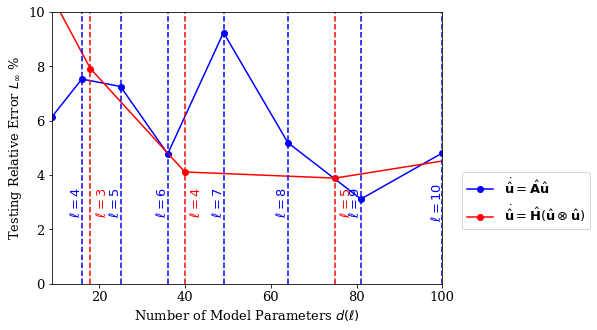

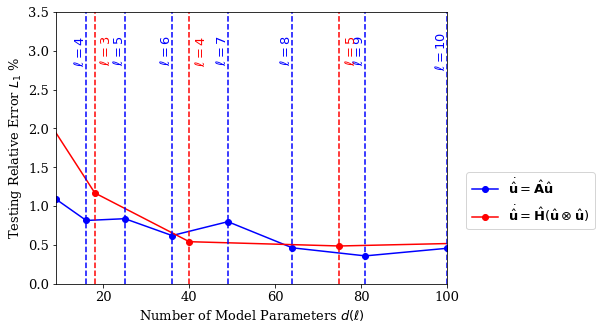

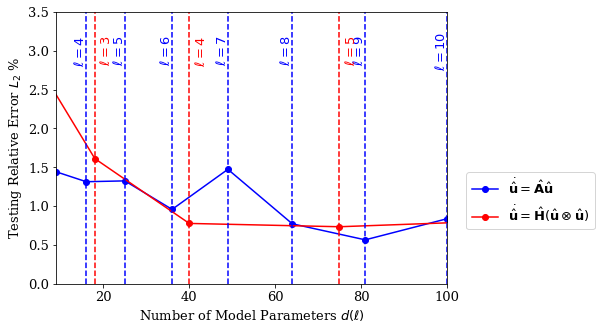

In [25]:
for norm in range(3):
    fig, ax = plt.subplots(figsize=(7, 5))

    A_results_testing = np.zeros(len(rank_array))
    H_results_testing = np.zeros(len(rank_array))

    for ii in range(len(rank_array)):
        # optimal coefficients based on training error
        coeff_A = np.argmin(training_error_A[:, ii, 0])
        coeff_H = np.argmin(training_error_H[:, ii, 0])
        # save the corresponding testing error
        A_results_testing[ii] = 100*testing_error_A[coeff_A, ii, norm]
        H_results_testing[ii] = 100*testing_error_H[coeff_H, ii, norm]

    ax.plot(d_A(rank_array), A_results_testing,"-o", c="b", label="$\dot{\hat{\mathbf{u}}} = \hat{\mathbf{A}}\hat{\mathbf{u}}$")
    ax.plot(d_H(rank_array), H_results_testing,"-o", c="r", label="$\dot{\hat{\mathbf{u}}} = \hat{\mathbf{H}}(\hat{\mathbf{u}} \otimes \hat{\mathbf{u}})$")

    ax.axvline(d_H(5), ls="--", c="r")
    ax.axvline(d_H(4), ls="--", c="r")
    ax.axvline(d_H(3), ls="--", c="r")

    ax.axvline(d_A(4), ls="--", c="b")
    ax.axvline(d_A(5), ls="--", c="b")
    ax.axvline(d_A(6), ls="--", c="b")
    ax.axvline(d_A(7), ls="--", c="b")
    ax.axvline(d_A(8), ls="--", c="b")
    ax.axvline(d_A(9), ls="--", c="b")
    ax.axvline(d_A(10), ls="--", c="b")

    _ = ax.text(d_A(4)-3, 3,  "$\ell=4$", c="b", rotation=90, verticalalignment='center')
    _ = ax.text(d_A(5)-3, 3,  "$\ell=5$", c="b", rotation=90, verticalalignment='center')
    _ = ax.text(d_A(6)-3, 3,  "$\ell=6$", c="b", rotation=90, verticalalignment='center')
    _ = ax.text(d_A(7)-3, 3,  "$\ell=7$", c="b", rotation=90, verticalalignment='center')
    _ = ax.text(d_A(8)-3, 3,  "$\ell=8$", c="b", rotation=90, verticalalignment='center')
    _ = ax.text(d_A(9)-3, 3,  "$\ell=9$", c="b", rotation=90, verticalalignment='center')
    _ = ax.text(d_A(10)-3, 3,  "$\ell=10$", c="b", rotation=90, verticalalignment='center')


    _ = ax.legend(loc=(1.05, .2))
    _ = ax.set_xlim(9, 100)
    if norm == 0:
        _ = ax.set_ylabel("Testing Relative Error $L_{\infty}$ %")
        _ = ax.set_ylim(0, 10)
        _ = ax.text(d_H(4)+1, 3,  "$\ell=4$", c="r", rotation=90, verticalalignment='center')
        _ = ax.text(d_H(5)+1, 3,  "$\ell=5$", c="r", rotation=90, verticalalignment='center')
        _ = ax.text(d_H(3)+1, 3,  "$\ell=3$", c="r", rotation=90, verticalalignment='center')
    if norm ==1:
        _ = ax.set_ylabel("Testing Relative Error $L_{1}$ %")
        _ = ax.set_ylim(0, 3.5)
        _ = ax.text(d_H(4)+1, 3,  "$\ell=4$", c="r", rotation=90, verticalalignment='center')
        _ = ax.text(d_H(5)+1, 3,  "$\ell=5$", c="r", rotation=90, verticalalignment='center')
        _ = ax.text(d_H(3)+1, 3,  "$\ell=3$", c="r", rotation=90, verticalalignment='center')
    if norm ==2:
        _ = ax.set_ylabel("Testing Relative Error $L_{2}$ %")
        _ = ax.set_ylim(0, 3.5)
        _ = ax.text(d_H(4)+1, 3,  "$\ell=4$", c="r", rotation=90, verticalalignment='center')
        _ = ax.text(d_H(5)+1, 3,  "$\ell=5$", c="r", rotation=90, verticalalignment='center')
        _ = ax.text(d_H(3)+1, 3,  "$\ell=3$", c="r", rotation=90, verticalalignment='center')
    _ = ax.set_xlabel(r"Number of Model Parameters $d(\ell)$")

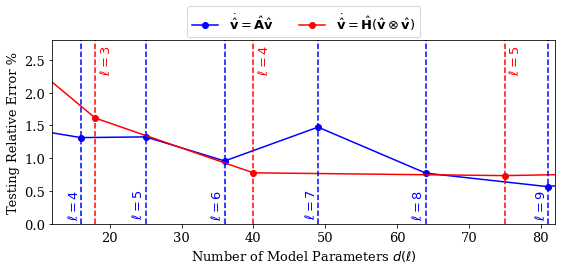

In [58]:
fig, ax = plt.subplots(figsize=(8, 4))

A_results_testing = np.zeros(len(rank_array))
H_results_testing = np.zeros(len(rank_array))

for ii in range(len(rank_array)):
    # optimal coefficients based on training error
    coeff_A = np.argmin(training_error_A[:, ii, 0])
    coeff_H = np.argmin(training_error_H[:, ii, 0])
    # save the corresponding testing error
    A_results_testing[ii] = 100*testing_error_A[coeff_A, ii, 2]
    H_results_testing[ii] = 100*testing_error_H[coeff_H, ii, 2]

ax.plot(d_A(rank_array), A_results_testing,"-o", c="b", label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{A}}\hat{\mathbf{v}}$")
ax.plot(d_H(rank_array), H_results_testing,"-o", c="r", label="$\dot{\hat{\mathbf{v}}} = \hat{\mathbf{H}}(\hat{\mathbf{v}} \otimes \hat{\mathbf{v}})$")

ax.axvline(d_H(5), ls="--", c="r")
ax.axvline(d_H(4), ls="--", c="r")
ax.axvline(d_H(3), ls="--", c="r")

ax.axvline(d_A(4), ls="--", c="b")
ax.axvline(d_A(5), ls="--", c="b")
ax.axvline(d_A(6), ls="--", c="b")
ax.axvline(d_A(7), ls="--", c="b")
ax.axvline(d_A(8), ls="--", c="b")
ax.axvline(d_A(9), ls="--", c="b")

_ = ax.text(d_A(4)-2, 0.3,  "$\ell=4$", c="b", rotation=90, verticalalignment='center')
_ = ax.text(d_A(5)-2, 0.3,  "$\ell=5$", c="b", rotation=90, verticalalignment='center')
_ = ax.text(d_A(6)-2, 0.3,  "$\ell=6$", c="b", rotation=90, verticalalignment='center')
_ = ax.text(d_A(7)-2, 0.3,  "$\ell=7$", c="b", rotation=90, verticalalignment='center')
_ = ax.text(d_A(8)-2, 0.3,  "$\ell=8$", c="b", rotation=90, verticalalignment='center')
_ = ax.text(d_A(9)-2, 0.3,  "$\ell=9$", c="b", rotation=90, verticalalignment='center')

_ = ax.legend(bbox_to_anchor=[0.5, 1.1],loc='center', ncol=2)
_ = ax.set_xlim(12, 82)
_ = ax.set_ylabel("Testing Relative Error %")
_ = ax.set_ylim(0, 2.8)
_ = ax.text(d_H(4)+0.5, 2.5,  "$\ell=4$", c="r", rotation=90, verticalalignment='center')
_ = ax.text(d_H(5)+0.5, 2.5,  "$\ell=5$", c="r", rotation=90, verticalalignment='center')
_ = ax.text(d_H(3)+0.5, 2.5,  "$\ell=3$", c="r", rotation=90, verticalalignment='center')
_ = ax.set_xlabel(r"Number of Model Parameters $d(\ell)$")

plt.tight_layout()
plt.savefig("HUX/figs/number_of_model_parameters_HUX.png", dpi=600)

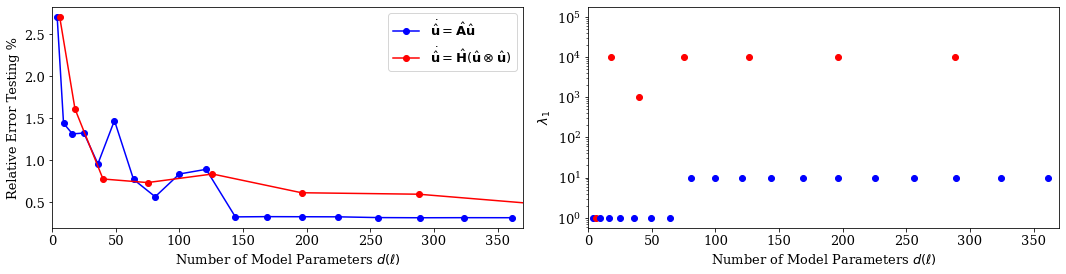

In [51]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

A_results_testing = np.zeros(len(rank_array))
H_results_testing = np.zeros(len(rank_array))

for ii in range(len(rank_array)):
    # optimal coefficients based on training error
    coeff_A = np.argmin(training_error_A[:, ii, 0])
    coeff_H = np.argmin(training_error_H[:, ii, 0])
    # save the corresponding testing error
    A_results_testing[ii] = 100*testing_error_A[coeff_A, ii, 2]
    H_results_testing[ii] = 100*testing_error_H[coeff_H, ii, 2]
    # plot coefficient
    ax[1].scatter(d_A(rank_array[ii]), 10**coeff_A, c="blue")
    ax[1].scatter(d_H(rank_array[ii]), 10**coeff_H, c="red")

ax[1].set_yscale("log")

ax[0].plot(d_A(rank_array), A_results_testing,"-o", c="b", label="$\dot{\hat{\mathbf{u}}} = \hat{\mathbf{A}}\hat{\mathbf{u}}$")
ax[0].plot(d_H(rank_array), H_results_testing,"-o", c="r", label="$\dot{\hat{\mathbf{u}}} = \hat{\mathbf{H}}(\hat{\mathbf{u}} \otimes \hat{\mathbf{u}})$")
ax[0].set_xlim(0, 370)
ax[1].set_xlim(0, 370)
ax[0].legend()

_ = ax[1].set_xlabel(r"Number of Model Parameters $d(\ell)$")
_ = ax[0].set_xlabel(r"Number of Model Parameters $d(\ell)$")
_ = ax[1].set_ylabel(r"$\lambda_{1}$")
_ = ax[0].set_ylabel(r"Relative Error Testing %")
plt.tight_layout()